В этой практике вы познакомитесь с тем как строить пайплайн для решения задачи обучения с учителем. На самом деле строить пайплайн с нуля даже для такой задачи как классификация кошек и собак довольно трудоемко для первой практики, поэтому многие шаги я уже приготовил. Вам нужно реализовать ключевые куски чтобы сложить картину целиком.
Для того чтобы выполнить практику, поставьте [Anaconda](https://www.anaconda.com/download) - она содержит нужные для работы библиотеки.

Зарегистрируйтесь на платформе https://kaggle.com и посмотрите конкурс https://www.kaggle.com/c/dogs-vs-cats

Скачайте данные этого конкурса https://www.kaggle.com/c/3362/download-all. Наш проект будет построен по т.н. схеме [cookiecutter](https://drivendata.github.io/cookiecutter-data-science/#cookiecutter-data-science) (прочитать про неё полезно, но не обязательно), поэтому скачанные данные распакуйте и поместите в папку `data/` внутри проекта (на деле если вы используете ссылку выше нужно распаковать дважды - архив и архивы внутри архива). Если вы используете `git`, то добавьте папку `data/` в файл `.gitignore`.

Данные для каждой практики персональны для каждого студента. Введите свое имя, фамилию и группу в строковую переменную STUDENT_ID (в произвольной форме) - это ваш уникальный идентификатор.

In [1]:
STUDENT_ID = "<Zorikov>"

Чтение данных
====

Обработаем данные. Этот шаг я сделаю за вас в силу некоторой его трудоемкости. Используем библиотеки pandas, numpy и Pillow.
- Введение в pandas и numpy можно посмотреть в первом уроке курса mlcourse_open: 
- https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic01_pandas_data_analysis/lesson1_part0_numpy.ipynb
- https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic01_pandas_data_analysis/lesson1_part1_pandas_intro.ipynb
- Pillow - одна из самых распространенных библиотек для работы с изображениями в python.

In [2]:
import pandas as pd
import pathlib
import hashlib
import numpy as np
import random


train_directory = pathlib.Path("data/train")
sample_size = 5000

def initialize_random_seed():
    """Инициализирует ГПСЧ из STUDENT_ID"""
    sha256 = hashlib.sha256()
    sha256.update(STUDENT_ID.encode("utf-8"))
    
    fingerprint = int(sha256.hexdigest(), 16) % (2**32) 
    
    random.seed(fingerprint)
    np.random.seed(fingerprint)


def read_target_variable():
    """Прочитаем разметку фотографий из названий файлов"""
    target_variable = {
        "filename": [],
        "is_cat": []
    }
    image_paths = list(train_directory.glob("*.jpg"))
    random.shuffle(image_paths)
    for image_path in image_paths[:sample_size]:
        filename = image_path.name
        class_name = filename.split(".")[0]
        target_variable["filename"].append(filename)
        target_variable["is_cat"].append(class_name == "cat")

    return pd.DataFrame(data=target_variable)


initialize_random_seed()

target_df = read_target_variable()
target_df

,filename,is_cat
0,dog.8050.jpg,False
1,cat.656.jpg,True
2,dog.2739.jpg,False
3,cat.11319.jpg,True
4,cat.4516.jpg,True
...,...,...
4995,dog.8327.jpg,False
4996,cat.8016.jpg,True
4997,dog.7108.jpg,False
4998,dog.8810.jpg,False


Обработка изображений
====

Используем изображения в качестве признакового описания. Признаками будут значения конкретных пикселей.

In [3]:
from PIL import Image
from tqdm import tqdm_notebook


def read_data(target_df):
    """Читает данные изображений и строит их признаковое описание"""
    image_size = (100, 100)
    features = []
    target = []
    for i, image_name, is_cat in tqdm_notebook(target_df.itertuples(), total=len(target_df)):
        image_path = str(train_directory / image_name)
        image = Image.open(image_path)
        image = image.resize(image_size) # уменьшаем изображения
        image = image.convert('LA') # преобразуем в Ч\Б
        pixels = np.asarray(image)[:, :, 0]
        pixels = pixels.flatten()
        features.append(pixels)
        target.append(is_cat)
    return np.array(features), np.array(target)

features, target = read_data(target_df)
features

array([[ 48,  50,  46, ...,  82,  84,  79],
       [ 87, 101, 100, ...,   8,   8,   8],
       [137, 126, 138, ..., 250, 252, 252],
       ...,
       [ 31,  27,  29, ..., 211, 227, 228],
       [177, 180, 182, ...,  99, 132, 144],
       [ 93,  87,  82, ..., 172, 169, 152]], dtype=uint8)

Разбиение на обучающую, валидационную и тестовую выборки
====

Сделайте обучающую, валидационную и тестовую выборки в пропорции 60/20/20. Используйте библиотеку scikit-learn (метод train_test_split). 

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Советую изучить готовый пайплайн для другой задачи, чтобы примерно понимать что требуется делать дальше (в отличии от нашего пайплайна тут нет валидационного множества): https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html 


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

random_state = check_random_state(7)
permutation = random_state.permutation(features.shape[0])
features = features[permutation]
target = target[permutation]
features = features.reshape((features.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [5]:
sum(y_train)

1532

Обучение модели
====

Попробуйте обучить модель `sklearn.linear_model.SGDClassifier` на полученных данных. Если это занимает слишком много времени и ресурсов - уменьшайте размер выборки (переменная sample_size).

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [6]:
from sklearn import linear_model

sgd_clf = linear_model.SGDClassifier(loss='log', max_iter=5000)
sgd_clf.fit(X_train, y_train)

print(sgd_clf.score(X_val, y_val))
print(sgd_clf.score(X_test, y_test))

0.51
0.523


Настройка гиперпараметров
====

Подберите скорость обучения модели, оценивая долю верных ответов (scikit-learn accuracy_score) на валидационном множестве (подбираем параметр `eta0` в отрезке [0, 1] указав параметр `learning_rate="constant"`).

In [7]:
sgd_tuned_clf = linear_model.SGDClassifier(loss='log', learning_rate='constant', eta0=0.0001, penalty='l1')

sgd_tuned_clf.fit(X_train, y_train)

print(sgd_tuned_clf.score(X_val, y_val))

0.507


Оценка результатов
====

Оцените долю верных ответов модели (scikit-learn accuracy_score). Каков уровень переобучения?

In [8]:
print(sgd_tuned_clf.score(X_train, y_train))

0.9396666666666667


# Реализация через LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_clf.fit(X_train, y_train)

print(log_reg_clf.score(X_val, y_val))
print(log_reg_clf.score(X_test, y_test))

0.509
0.51


Нормализация данных
====

Сделайте нормализацию данных с помощью StandardScaler из библиотеки sklearn (scaler.fit_transform на train и validation, scaler.transform на test). Оцените долю верных ответов модели на тестовой выборке. Какова ситуация теперь?

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

sgd_scaled_and_tuned_clf = linear_model.SGDClassifier(loss='log', learning_rate='constant', eta0=0.001)
sgd_scaled_and_tuned_clf.fit(X_train, y_train)

print(sgd_scaled_and_tuned_clf.score(X_val, y_val))
print(sgd_scaled_and_tuned_clf.score(X_test, y_test))

0.524
0.516


In [11]:
log_reg_scaled_clf = LogisticRegression(C=0.05, penalty='l1', solver='saga', tol=0.01)
log_reg_scaled_clf.fit(X_train, y_train)

print(log_reg_scaled_clf.score(X_val, y_val))
print(log_reg_scaled_clf.score(X_test, y_test))

0.542
0.561


# ROC curves and ROC-AUC

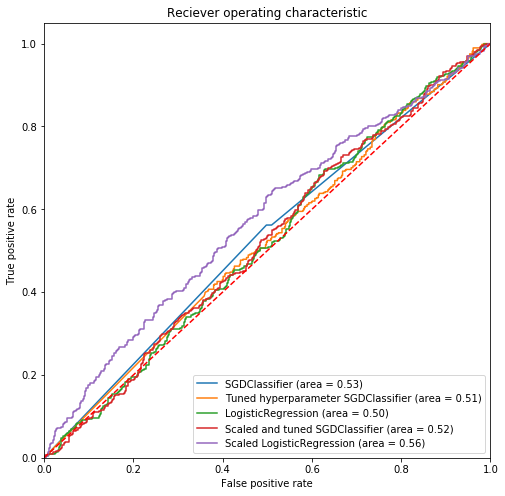

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

# size in inches
plt.figure(figsize=(8, 8))

sgd_roc_auc = roc_auc_score(y_test, sgd_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, sgd_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='SGDClassifier (area = %0.2f)' % sgd_roc_auc)

sgd_tuned_roc_auc = roc_auc_score(y_test, sgd_tuned_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, sgd_tuned_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Tuned hyperparameter SGDClassifier (area = %0.2f)' % sgd_tuned_roc_auc)

log_reg_roc_auc = roc_auc_score(y_test, log_reg_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='LogisticRegression (area = %0.2f)' % log_reg_roc_auc)

sgd_scaled_and_tuned_roc_auc = roc_auc_score(y_test, sgd_scaled_and_tuned_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, sgd_scaled_and_tuned_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Scaled and tuned SGDClassifier (area = %0.2f)' % sgd_scaled_and_tuned_roc_auc)

log_reg_scaled_roc_auc = roc_auc_score(y_test, log_reg_scaled_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg_scaled_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Scaled LogisticRegression (area = %0.2f)' % log_reg_scaled_roc_auc)


plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Reciever operating characteristic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

Сабмит на kaggle
====

(Опционально) сделайте сабмит в конкурсе https://www.kaggle.com/c/dogs-vs-cats (это простой бейзлайн, не ожидайте высокого результата)

# Random Forest

Примените RandomForest вместо SGDClassifier на этой задаче. Подберите количество деревьев, перебирая их в интервале от 100 до 400.


In [13]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# hyperparameter tuning (takes too much time)
# estimators = [1, 10, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 500]

# score_test = {}
# for estimator_number in estimators:
#     clf = RandomForestClassifier(n_estimators=estimator_number)
#     clf.fit(X_train, y_train)
#     score_test[estimator_number] = clf.score(X_test, y_test)
#     score_train = clf.score(X_train, y_train)
    
#     print(estimator_number, score_test[estimator_number], score_train)
    
# print("Test scores:", score_test)

In [14]:
rand_forest_clf = RandomForestClassifier(n_estimators=150)
rand_forest_clf.fit(X_train, y_train)
score = rand_forest_clf.score(X_test, y_test)
print(score)

0.649


Оцените качество RandomForest на кросс-валидации по пяти фолдам. Посмотрите на среднее и стандартное отклонение точности на кросс-валидации.

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rand_forest_clf, X_train, y_train, cv=5)

In [16]:
scores

array([0.6267166 , 0.61173533, 0.61      , 0.60826033, 0.63954944])

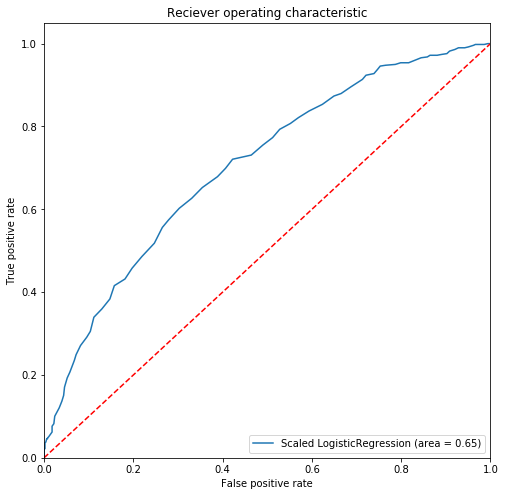

In [20]:
plt.figure(figsize=(8, 8))

rand_forest_roc_auc = roc_auc_score(y_test, rand_forest_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rand_forest_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Scaled LogisticRegression (area = %0.2f)' % rand_forest_roc_auc)


plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Reciever operating characteristic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

# The end